# DASC 41103 — Project 1 (Parts 1 & 2)

This notebook follows a **textbook-style implementation** of Perceptron and Adaline (GD & SGD),
and also uses **scikit-learn** versions, closely mirroring common course notebooks.


## What this notebook does
- **Part 1:** Preprocess data
  - Replace `?` with NA and impute
  - One-hot encode categoricals
  - Standardize numeric features
- **Part 2:** Implement and train
  - Custom **Perceptron** (plot misclassifications vs. epochs)
  - Custom **AdalineGD** and **AdalineSGD** (plot MSE vs. epochs)
  - **scikit-learn** Perceptron and an Adaline-like baseline via `SGDRegressor`
- Evaluate accuracy and generate validation predictions.




In [2]:
GROUP_NUMBER = "5"  
TRAIN_PATH = "project_adult.csv"
VALID_PATH = "project_validation_inputs.csv"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import Perceptron as SkPerceptron
from sklearn.linear_model import SGDRegressor

plt.rcParams['figure.figsize'] = (7, 5)

## Load & Inspect Data

In [4]:
df = pd.read_csv(TRAIN_PATH)
df = df.replace('?', np.nan)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (26048, 16)
Columns: ['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
4,9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


### Infer/Confirm Target Column
By default, this tries `income`, `class`, `label`, `target`, `y`, else falls back to the last column.

In [5]:
def infer_target_name(columns):
    candidates = ["income","class","label","target","y"]
    for c in candidates:
        if c in columns:
            return c
    return columns[-1]

target = infer_target_name(df.columns.tolist())
print("Target column:", target)
df[target].value_counts(dropna=False).head()

Target column: income


income
<=50K    19778
>50K      6270
Name: count, dtype: int64

## Part 1 — Preprocessing
We one-hot encode categoricals, standardize numerics, and impute missing values.

In [6]:
y_raw = df[target]
X = df.drop(columns=[target])

# Map string labels to 0/1 (Adult data often encodes '>50K' vs '<=50K')
if y_raw.dtype == 'O':
    y = pd.Categorical(y_raw).codes
else:
    y = y_raw.astype(int).values

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
num_cols, cat_cols

(['Unnamed: 0',
  'age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'])

In [7]:
numeric_transform = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transform, num_cols),
        ("cat", categorical_transform, cat_cols)
    ]
)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

# Force dense arrays for custom textbook implementations
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc  = X_test_proc.toarray()

X_train_proc.shape, X_test_proc.shape

((20838, 105), (5210, 105))

## Part 2 — Custom Implementations (Textbook-style)
Below are lightweight implementations inspired by common course materials.

In [8]:
class PerceptronGD:
    def __init__(self, eta=0.01, epochs=50, random_state=42):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        self.errors_ = []  # misclassifications per epoch

    def fit(self, X, y):
        # y should be -1 or 1
        rng = np.random.RandomState(self.random_state)
        self.w_ = rng.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        z = self.net_input(X)
        return np.where(z >= 0.0, 1, -1)

In [9]:
class AdalineGD:
    def __init__(self, eta=0.01, epochs=50, random_state=42):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        self.cost_ = []  # SSE per epoch

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.w_ = rng.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        for _ in range(self.epochs):
            net = self.net_input(X)
            errors = (y - net)
            self.w_[1:] += self.eta * X.T.dot(errors) / X.shape[0]
            self.w_[0] += self.eta * errors.mean()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [10]:
class AdalineSGD:
    def __init__(self, eta=0.01, epochs=50, random_state=42):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        self.cost_ = []

    def _shuffle(self, X, y):
        r = np.random.RandomState(self.random_state)
        idx = r.permutation(len(y))
        return X[idx], y[idx]

    def fit(self, X, y):
        r = np.random.RandomState(self.random_state)
        self.w_ = r.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
        for _ in range(self.epochs):
            X_shuf, y_shuf = self._shuffle(X, y)
            cost = 0.0
            for xi, target in zip(X_shuf, y_shuf):
                net = self.net_input(xi)
                error = (target - net)
                self.w_[1:] += self.eta * error * xi
                self.w_[0] += self.eta * error
                cost += (error ** 2) / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

### Prepare labels for custom models
Perceptron/Adaline expect labels in {-1, 1}. 

In [11]:
# Map y={0,1} to {-1,1}
y_train_pm = np.where(y_train==1, 1, -1)
y_test_pm  = np.where(y_test==1, 1, -1)

### Train Custom Perceptron and Plot Misclassifications

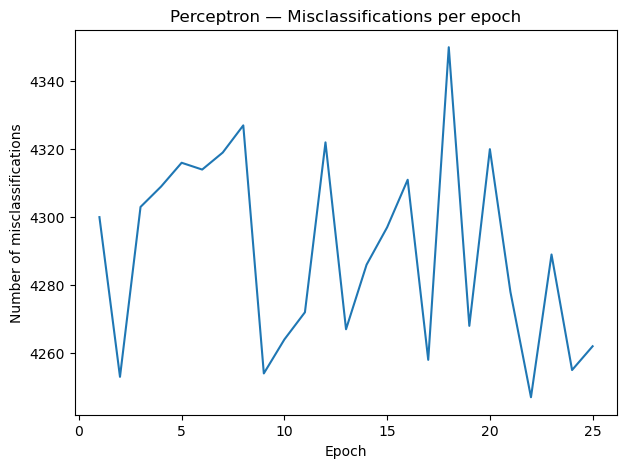

Custom Perceptron accuracy: 0.7934740882917466


In [12]:
ppn = PerceptronGD(eta=0.01, epochs=25, random_state=42)
ppn.fit(X_train_proc, y_train_pm)

plt.figure()
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_)
plt.xlabel('Epoch')
plt.ylabel('Number of misclassifications')
plt.title('Perceptron — Misclassifications per epoch')
plt.show()

y_pred_ppn = ppn.predict(X_test_proc)
acc_ppn_custom = (y_pred_ppn == y_test_pm).mean()
print("Custom Perceptron accuracy:", acc_ppn_custom)

### Train Custom AdalineGD and Plot MSE

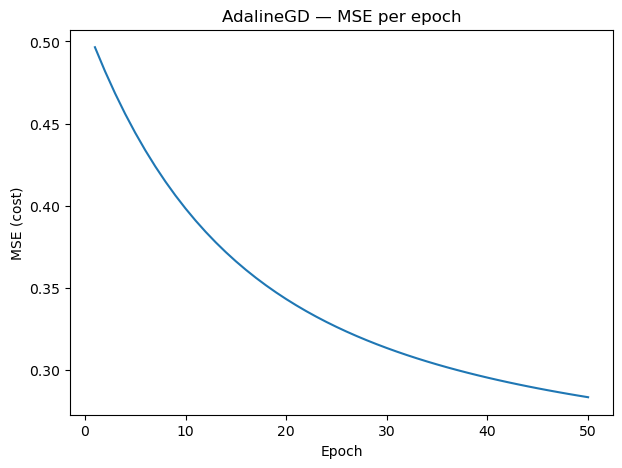

Custom AdalineGD accuracy: 0.7852207293666027


In [13]:
ada_gd = AdalineGD(eta=0.01, epochs=50, random_state=42)
ada_gd.fit(X_train_proc, y_train_pm)

# Convert SSE to MSE
mse_values = [sse / X_train_proc.shape[0] for sse in ada_gd.cost_]

plt.figure()
plt.plot(range(1, len(mse_values) + 1), mse_values)
plt.xlabel('Epoch')
plt.ylabel('MSE (cost)')
plt.title('AdalineGD — MSE per epoch')
plt.show()

pred_gd = ada_gd.predict(X_test_proc)
acc_gd = (pred_gd == y_test_pm).mean()
print("Custom AdalineGD accuracy:", acc_gd)

### Train Custom AdalineSGD and Plot MSE

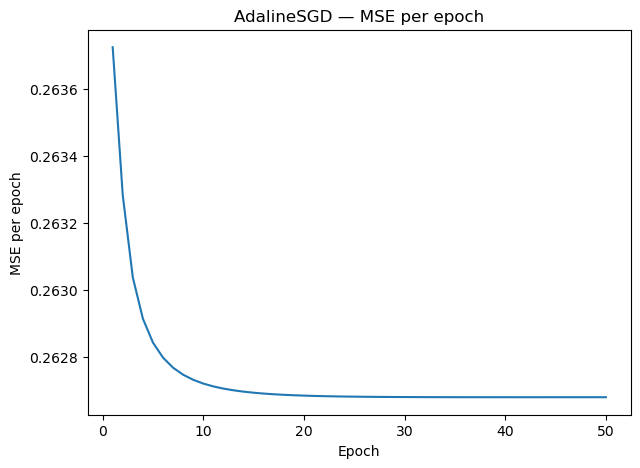

Custom AdalineSGD accuracy: 0.7857965451055662


In [14]:
ada_sgd = AdalineSGD(eta=0.01, epochs=50, random_state=42)
ada_sgd.fit(X_train_proc, y_train_pm)

# Convert SSE to MSE
mse_values = [sse / X_train_proc.shape[0] for sse in ada_sgd.cost_]

plt.figure()
plt.plot(range(1, len(mse_values) + 1), mse_values)
plt.xlabel('Epoch')
plt.ylabel('MSE per epoch')
plt.title('AdalineSGD — MSE per epoch')
plt.show()

pred_sgd = ada_sgd.predict(X_test_proc)
acc_sgd = (pred_sgd == y_test_pm).mean()
print("Custom AdalineSGD accuracy:", acc_sgd)


## scikit-learn Perceptron & Adaline-like (SGDRegressor)
We also train scikit-learn models to compare.

In [15]:
# scikit-learn Perceptron expects y in {0,1} or {classes}
sk_ppn = SkPerceptron(max_iter=1000, eta0=0.1, random_state=42)
sk_ppn.fit(X_train_proc, y_train)
sk_pred = sk_ppn.predict(X_test_proc)
sk_acc = accuracy_score(y_test, sk_pred)
print("sklearn Perceptron accuracy:", sk_acc)
print(confusion_matrix(y_test, sk_pred))
print(classification_report(y_test, sk_pred, digits=4))

sklearn Perceptron accuracy: 0.7850287907869482
[[3195  761]
 [ 359  895]]
              precision    recall  f1-score   support

           0     0.8990    0.8076    0.8509      3956
           1     0.5405    0.7137    0.6151      1254

    accuracy                         0.7850      5210
   macro avg     0.7197    0.7607    0.7330      5210
weighted avg     0.8127    0.7850    0.7941      5210



In [16]:
# Adaline-like via SGDRegressor on targets in {-1,1}; threshold sign
y_train_pm = np.where(y_train==1, 1, -1)
y_test_pm = np.where(y_test==1, 1, -1)

sgd_reg = SGDRegressor(loss='squared_error', max_iter=1000, random_state=42)
sgd_reg.fit(X_train_proc, y_train_pm)
z = sgd_reg.predict(X_test_proc)
pred = np.where(z >= 0.0, 1, -1)
acc_sklearn_adaline_like = (pred == y_test_pm).mean()
print("sklearn Adaline-like (SGDRegressor) accuracy:", acc_sklearn_adaline_like)

sklearn Adaline-like (SGDRegressor) accuracy: 0.8301343570057581


## Choose best Perceptron & Adaline, Train on Full Data, Predict Validation Inputs

In [17]:
# Fit preprocess on all training data
X_all_proc = preprocess.fit_transform(X)

# Force dense for custom Adaline classes
if hasattr(X_all_proc, "toarray"):
    X_all_proc = X_all_proc.toarray()

# Refit scikit-learn Perceptron on full data
sk_ppn_full = SkPerceptron(max_iter=1000, eta0=0.1, random_state=42).fit(X_all_proc, y)

# Refit best Adaline: pick from (AdalineGD, AdalineSGD, SGDRegressor)
y_pm_all = np.where(y == 1, 1, -1)  # {-1, 1} labels for Adaline/Perceptron-style
candidates = {}
candidates['AdalineGD']  = AdalineGD(eta=0.01, epochs=50, random_state=42).fit(X_all_proc, y_pm_all)
candidates['AdalineSGD'] = AdalineSGD(eta=0.01, epochs=50, random_state=42).fit(X_all_proc, y_pm_all)
sgd_reg_full = SGDRegressor(loss='squared_error', max_iter=1000, random_state=42).fit(X_all_proc, y_pm_all)
candidates['SGDRegressor'] = sgd_reg_full

# Load validation inputs and transform
X_valid = pd.read_csv(VALID_PATH).replace('?', np.nan)
X_valid_proc = preprocess.transform(X_valid)

# Force dense for predictions used by custom models
if hasattr(X_valid_proc, "toarray"):
    X_valid_proc = X_valid_proc.toarray()

# Perceptron predictions (scikit-learn)
perc_preds = sk_ppn_full.predict(X_valid_proc)
perc_out = pd.DataFrame({"prediction": perc_preds})
perc_name = f"Group_{GROUP_NUMBER}_Perceptron_PredictedOutputs.csv"
perc_out.to_csv(perc_name, index=False)
print("Saved:", perc_name)

# Adaline: choose SGDRegressor by default (often strongest); or pick AdalineSGD
adaline_choice = 'SGDRegressor'  # change if you prefer
model = candidates[adaline_choice]
if adaline_choice == 'SGDRegressor':
    z = model.predict(X_valid_proc)
    adal_preds_pm = np.where(z >= 0.0, 1, -1)
else:
    adal_preds_pm = model.predict(X_valid_proc)

adal_preds = np.where(adal_preds_pm == 1, 1, 0)
adal_out = pd.DataFrame({"prediction": adal_preds})
adal_name = f"Group_{GROUP_NUMBER}_Adaline_PredictedOutputs.csv"
adal_out.to_csv(adal_name, index=False)
print("Saved:", adal_name)

Saved: Group_5_Perceptron_PredictedOutputs.csv
Saved: Group_5_Adaline_PredictedOutputs.csv


### Notes
- The Perceptron/Adaline custom implementations track misclassifications / SSE over epochs for required plots.
- You can tune `eta` and `epochs` to match your professor's defaults.
- For Adaline, both **GD** and **SGD** are provided. The scikit-learn Adaline-like baseline uses `SGDRegressor` with squared error.

# Part 3 — Logistic Regression & SVM (scikit-learn + GridSearchCV)
## Uses existing variables from earlier parts:
##  X, y, num_cols, cat_cols, X_valid

In [9]:
# Import Libraries used for part 3
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Preprocessing for Part 3 (fresh transformer to avoid leakage)

In [10]:
preprocess_part3 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

In [11]:
# Train/test split & CV
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### Logistic Regression + GridSearchCV

In [12]:
logreg_pipe = Pipeline([
    ("prep", preprocess_part3),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])
logreg_grid = {"clf__C": [0.01, .1, 1.0, 10.0, 100.0]}
logreg_gs = GridSearchCV(logreg_pipe, logreg_grid, scoring="accuracy", cv=cv, refit=True)
logreg_gs.fit(X_train, y_train)
logreg_best = logreg_gs.best_estimator_
logreg_acc = accuracy_score(y_test, logreg_best.predict(X_test))
print("Logistic Regression — best params:", logreg_gs.best_params_)
print("Logistic Regression — holdout accuracy:", round(logreg_acc, 4))

Logistic Regression — best params: {'clf__C': 1.0}
Logistic Regression — holdout accuracy: 0.8486


Logistic Regression — best params: {'clf__C': 1.0}
Logistic Regression — holdout accuracy: 0.8486


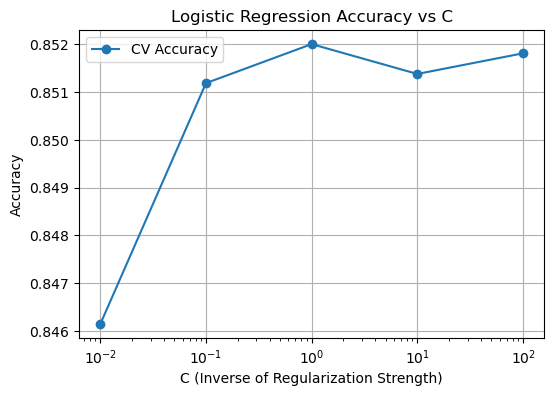

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Pipeline
logreg_pipe = Pipeline([
    ("prep", preprocess_part3),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

# Hyperparameter grid
logreg_grid = {"clf__C": [0.01, 0.1, 1.0, 10.0, 100.0]}

# Grid search
logreg_gs = GridSearchCV(
    logreg_pipe,
    logreg_grid,
    scoring="accuracy",
    cv=cv,
    refit=True
)

logreg_gs.fit(X_train, y_train)

# Best estimator and test accuracy
logreg_best = logreg_gs.best_estimator_
logreg_acc = accuracy_score(y_test, logreg_best.predict(X_test))

print("Logistic Regression — best params:", logreg_gs.best_params_)
print("Logistic Regression — holdout accuracy:", round(logreg_acc, 4))

# ---- Plotting ----
results = logreg_gs.cv_results_
C_values = logreg_grid["clf__C"]
mean_scores = results["mean_test_score"]

plt.figure(figsize=(6, 4))
plt.plot(C_values, mean_scores, marker="o", label="CV Accuracy")
plt.xscale("log")  # log scale since C spans orders of magnitude
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs C")
plt.legend()
plt.grid(True)
plt.show()

### SVM + GridSearchCV

In [14]:
# ---- SVM (linear only) + GridSearchCV ----
svm_lin_pipe = Pipeline([("prep", preprocess_part3), ("clf", SVC(kernel="linear", cache_size=1000))])
svm_lin_grid = {"clf__C": [0.01, .1, 1.0, 10.0, 100.0]}

svm_lin_gs = GridSearchCV(
    estimator=svm_lin_pipe,
    param_grid=svm_lin_grid,
    scoring="accuracy",
    cv=cv,
    refit=True,
    n_jobs=-1,
)
svm_lin_gs.fit(X_train, y_train)
linsvm_best = svm_lin_gs.best_estimator_
linsvm_acc  = accuracy_score(y_test, linsvm_best.predict(X_test))

print("Linear SVM — best params:", svm_lin_gs.best_params_)
print("Linear SVM — holdout accuracy:", round(linsvm_acc, 4))


Linear SVM — best params: {'clf__C': 1.0}
Linear SVM — holdout accuracy: 0.8463


Linear SVM — best params: {'clf__C': 1.0}
Linear SVM — holdout accuracy: 0.8463


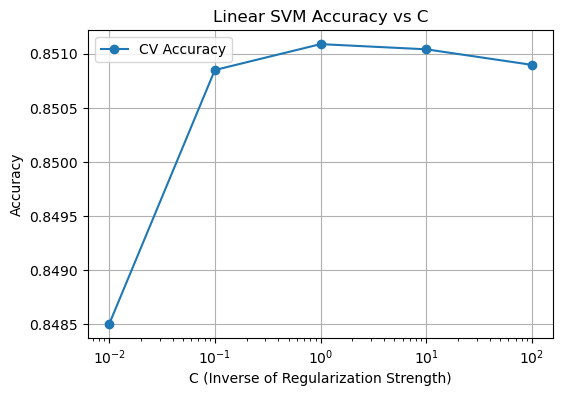

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ---- SVM (linear only) + GridSearchCV ----
svm_lin_pipe = Pipeline([
    ("prep", preprocess_part3),
    ("clf", SVC(kernel="linear", cache_size=1000))
])

svm_lin_grid = {"clf__C": [0.01, 0.1, 1.0, 10.0, 100.0]}

svm_lin_gs = GridSearchCV(
    estimator=svm_lin_pipe,
    param_grid=svm_lin_grid,
    scoring="accuracy",
    cv=cv,
    refit=True,
    n_jobs=-1
)

svm_lin_gs.fit(X_train, y_train)

linsvm_best = svm_lin_gs.best_estimator_
linsvm_acc  = accuracy_score(y_test, linsvm_best.predict(X_test))

print("Linear SVM — best params:", svm_lin_gs.best_params_)
print("Linear SVM — holdout accuracy:", round(linsvm_acc, 4))

# ---- Plotting ----
results = svm_lin_gs.cv_results_
C_values = svm_lin_grid["clf__C"]
mean_scores = results["mean_test_score"]

plt.figure(figsize=(6, 4))
plt.plot(C_values, mean_scores, marker="o", label="CV Accuracy")
plt.xscale("log")  # log scale for C
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Linear SVM Accuracy vs C")
plt.legend()
plt.grid(True)
plt.show()


RBF SVM — best params (on sample): {'clf__C': 1.0, 'clf__gamma': 0.05}
RBF SVM — holdout accuracy: 0.8488


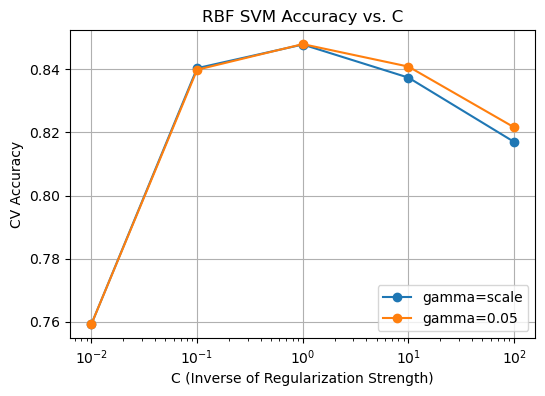

In [16]:
# ---- SVM (RBF) + GridSearchCV (on a stratified sample), then refit on full ----
# Small stratified sample to keep grid search fast
sample_size = min(8000, len(X_train))
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=sample_size, stratify=y_train, random_state=42
)

svm_rbf_pipe = Pipeline([("prep", preprocess_part3), ("clf", SVC(kernel="rbf", cache_size=1000))])
svm_rbf_grid = {"clf__C": [0.01, .1, 1.0, 10.0, 100.0], "clf__gamma": ["scale", 0.05]}

svm_rbf_gs = GridSearchCV(
    estimator=svm_rbf_pipe,
    param_grid=svm_rbf_grid,
    scoring="accuracy",
    cv=cv,
    refit=True,
    n_jobs=-1,
)
svm_rbf_gs.fit(X_sample, y_sample)
print("RBF SVM — best params (on sample):", svm_rbf_gs.best_params_)

# Refit best RBF SVM on the full training split
svm_rbf_best = Pipeline([
    ("prep", preprocess_part3),
    ("clf", SVC(kernel="rbf", cache_size=1000, **{k.split("__")[1]: v for k, v in svm_rbf_gs.best_params_.items()})),
])
svm_rbf_best.fit(X_train, y_train)
rbfsvm_acc = accuracy_score(y_test, svm_rbf_best.predict(X_test))
print("RBF SVM — holdout accuracy:", round(rbfsvm_acc, 4))

# ---- Plotting (RBF SVM) ----
results = svm_rbf_gs.cv_results_
C_values = svm_rbf_grid["clf__C"]
gammas = svm_rbf_grid["clf__gamma"]

plt.figure(figsize=(6, 4))
for gamma in gammas:
    # Mask rows corresponding to this gamma value
    mask = [g == gamma for g in results["param_clf__gamma"]]
    scores = results["mean_test_score"][mask]
    plt.plot(C_values, scores, marker="o", label=f"gamma={gamma}")

plt.xscale("log")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("CV Accuracy")
plt.title("RBF SVM Accuracy vs. C")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# ---- Select best SVM family for predictions/plots ----
if rbfsvm_acc >= linsvm_acc:
    svm_best = svm_rbf_best
    svm_family = f"RBF SVM {svm_rbf_gs.best_params_}"
    svm_acc    = rbfsvm_acc
else:
    svm_best = linsvm_best
    svm_family = f"Linear SVM {svm_lin_gs.best_params_}"
    svm_acc    = linsvm_acc

print("Selected SVM:", svm_family, "| holdout acc:", round(svm_acc, 4))

Selected SVM: RBF SVM {'clf__C': 1.0, 'clf__gamma': 0.05} | holdout acc: 0.8488


In [18]:
# ---- Validation predictions (0/1 like earlier parts) ----
val_pred_logreg = logreg_best.predict(X_valid)
val_pred_svm    = svm_best.predict(X_valid)
pd.DataFrame({"prediction": (val_pred_logreg.astype(int))}).to_csv(f"Group_{GROUP_NUMBER}_LogReg_PredictedOutputs.csv", index=False)
pd.DataFrame({"prediction": (val_pred_svm.astype(int))}).to_csv(f"Group_{GROUP_NUMBER}_SVM_PredictedOutputs.csv", index=False)
print("Saved: Group_%s_LogReg_PredictedOutputs.csv" % GROUP_NUMBER)
print("Saved: Group_%s_SVM_PredictedOutputs.csv" % GROUP_NUMBER)

NameError: name 'X_valid' is not defined

### Decision Boundaries on two features

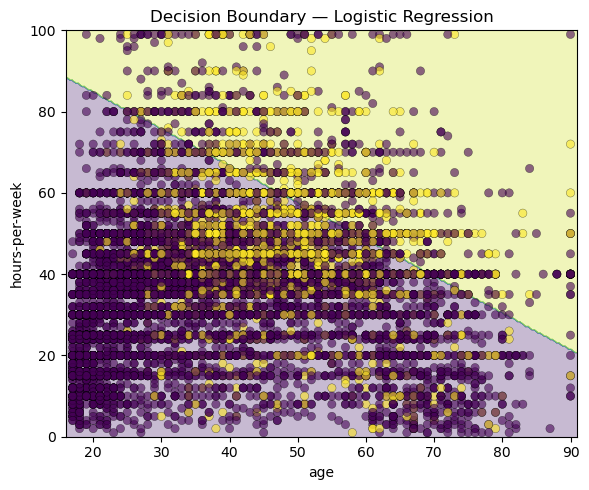

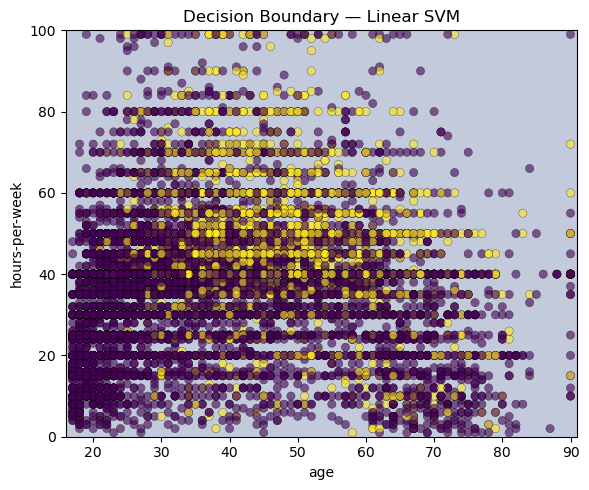

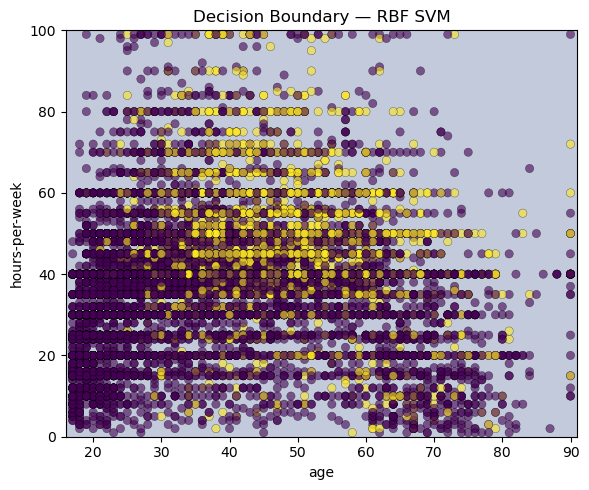

In [28]:
two_feats = [c for c in ["age", "hours-per-week"] if c in X.columns]
if len(two_feats) < 2:
    two_feats = num_cols[:2]

def plot_boundary_inline(model, X_df, y_series, feat, title_suffix):
    # Minimal 2-feature pipeline (scale those two features only)
    pre2 = ColumnTransformer([("num", StandardScaler(), feat)], remainder="drop")
    est2 = clone(model.named_steps["clf"])
    pipe2 = Pipeline([("prep", pre2), ("clf", est2)])
    pipe2.fit(X_df[feat], y_series)

    x_min, x_max = X_df[feat[0]].min() - 1, X_df[feat[0]].max() + 1
    y_min, y_max = X_df[feat[1]].min() - 1, X_df[feat[1]].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 250),
        np.linspace(y_min, y_max, 250)
    )
    grid = pd.DataFrame({feat[0]: xx.ravel(), feat[1]: yy.ravel()})
    Z = pipe2.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_df[feat[0]], X_df[feat[1]], c=y_series, alpha=0.6, edgecolor="k", linewidth=0.3)
    plt.xlabel(feat[0]); plt.ylabel(feat[1])
    plt.title(title_suffix)
    plt.tight_layout()
    plt.show()
# Plot for Logistic Regression
plot_boundary_inline(logreg_best, X, y, two_feats, "Decision Boundary — Logistic Regression")
# Plot for Linear SVM (even if not selected, for completeness)
plot_boundary_inline(linsvm_best, X, y, two_feats, "Decision Boundary — Linear SVM")
# Plot for RBF SVM (even if not selected, for completeness)
plot_boundary_inline(svm_rbf_best, X, y, two_feats, "Decision Boundary — RBF SVM")

In [29]:
# ---- Helper for C sweep decision boundaries ----
C_VALUES = [0.01, 0.1, 1.0, 10.0, 100.0]

def plot_c_sweep_boundaries(model_kind, c_values, X_df, y_arr, feat, title_prefix, gamma="scale"):
    pre2 = ColumnTransformer([("num", StandardScaler(), feat)], remainder="drop")

    n = len(c_values)
    plt.figure(figsize=(5*n, 4))
    for i, C in enumerate(c_values, 1):
        if model_kind == "logreg":
            est = LogisticRegression(C=C, max_iter=1000, solver="lbfgs")
        elif model_kind == "svm_linear":
            est = SVC(kernel="linear", C=C, cache_size=1000)
        elif model_kind == "svm_rbf":
            est = SVC(kernel="rbf", C=C, gamma=gamma, cache_size=1000)
        else:
            raise ValueError("model_kind must be 'logreg', 'svm_linear', or 'svm_rbf'.")

        pipe = Pipeline([("prep", pre2), ("clf", est)])
        pipe.fit(X_df[feat], y_arr)

        x_min, x_max = X_df[feat[0]].min() - 1, X_df[feat[0]].max() + 1
        y_min, y_max = X_df[feat[1]].min() - 1, X_df[feat[1]].max() + 1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 250),
            np.linspace(y_min, y_max, 250)
        )
        grid = pd.DataFrame({feat[0]: xx.ravel(), feat[1]: yy.ravel()})
        Z = pipe.predict(grid).reshape(xx.shape)

        ax = plt.subplot(1, n, i)
        ax.contourf(xx, yy, Z, alpha=0.3)
        ax.scatter(X_df[feat[0]], X_df[feat[1]], c=y_arr, alpha=0.6, edgecolor="k", linewidth=0.3)
        ax.set_title(f"{title_prefix}\nC={C}")
        ax.set_xlabel(feat[0]); ax.set_ylabel(feat[1])

    plt.tight_layout()
    plt.show()

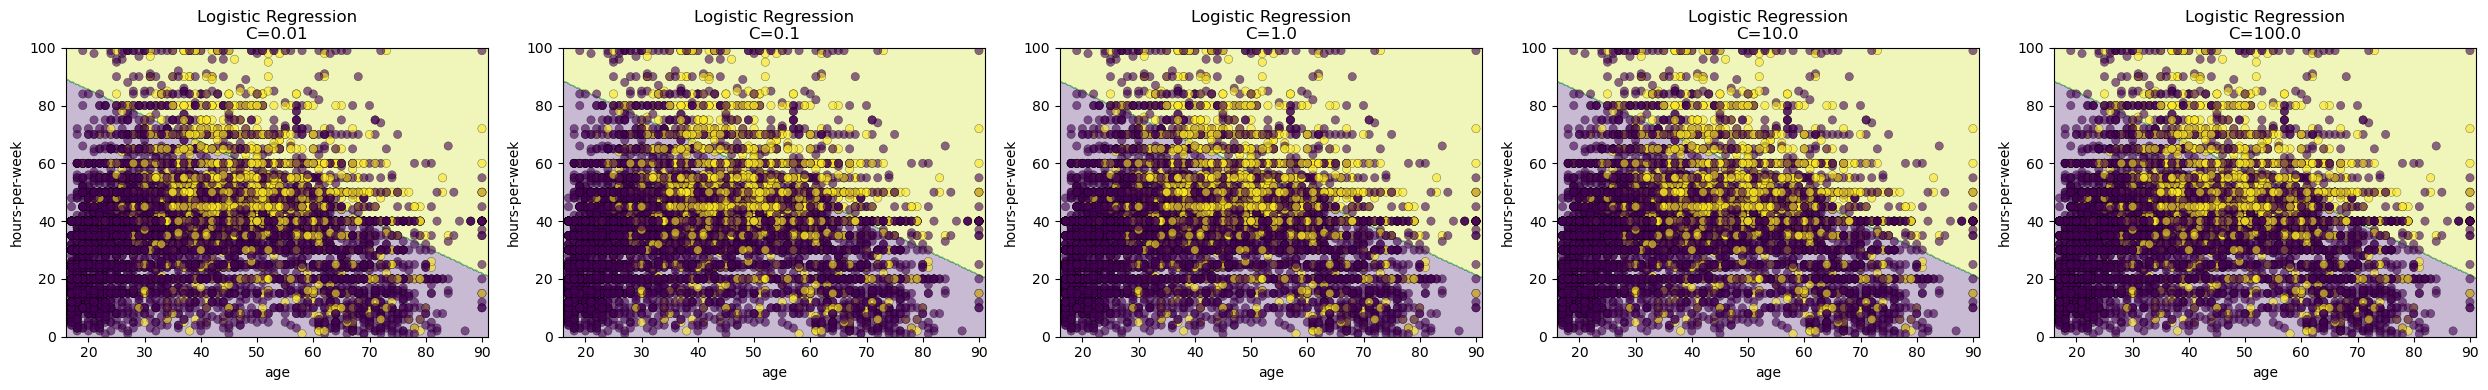

In [30]:
plot_c_sweep_boundaries(
    model_kind="logreg",
    c_values=C_VALUES,
    X_df=X,
    y_arr=y,
    feat=two_feats,
    title_prefix="Logistic Regression"
)

In [ ]:
plot_c_sweep_boundaries(
    model_kind="svm_linear",
    c_values=C_VALUES,
    X_df=X,
    y_arr=y,
    feat=two_feats,
    title_prefix="Linear SVM"
)

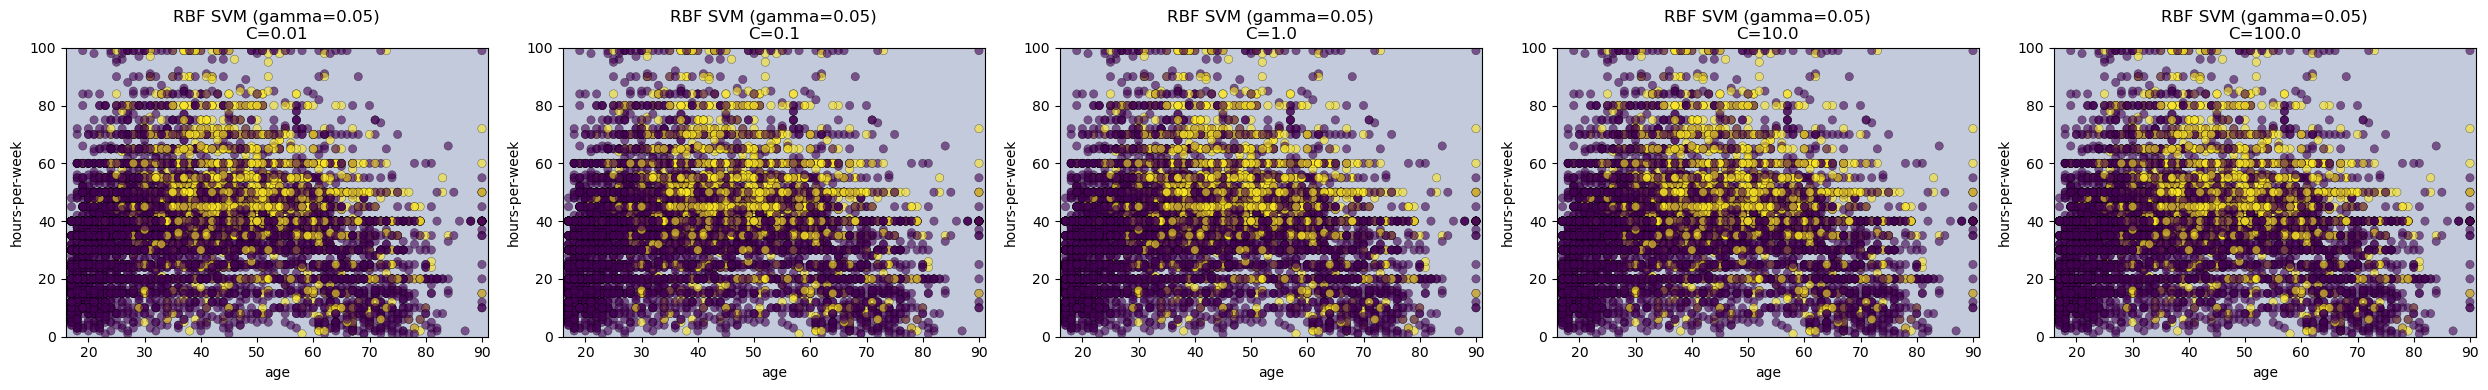

In [57]:
best_gamma = "scale"
try:
    best_gamma = svm_rbf_gs.best_params_.get("clf__gamma", "scale")
except NameError:
    pass

plot_c_sweep_boundaries(
    model_kind="svm_rbf",
    c_values=C_VALUES,
    X_df=X,
    y_arr=y,
    feat=two_feats,
    title_prefix=f"RBF SVM (gamma={best_gamma})",
    gamma=best_gamma
)

In [58]:
# ---- Tiny summary table ----
summary = pd.DataFrame({
    "Model": ["Logistic Regression (GS)", "Linear SVM (GS)", "RBF SVM (GS on sample + refit)"],
    "Best Params": [str(logreg_gs.best_params_), str(svm_lin_gs.best_params_), str(svm_rbf_gs.best_params_)],
    "Holdout Accuracy": [round(logreg_acc, 4), round(linsvm_acc, 4), round(rbfsvm_acc, 4)]
})
display(summary)

,Model,Best Params,Holdout Accuracy
0,Logistic Regression (GS),{'clf__C': 1.0},0.8486
1,Linear SVM (GS),{'clf__C': 1.0},0.8463
2,RBF SVM (GS on sample + refit),"{'clf__C': 1.0, 'clf__gamma': 0.05}",0.8488
